# Analysing RNA velocity
[LabEx CORTEX Bioinformatics Platform - Lyon 1 University -](https://labex-cortex.universite-lyon.fr/)<br>
Vignette produced by Emeric Texeraud

2022-01-25

### Packages

In [6]:
import scvelo as scv # main package
import anndata
import pandas as pd # To work with dataframes
import copy
import pickle # To save velocity object
import os
import csv # To load from/save to csv

After importing scvelo, we can verify the version.

In [7]:
scv.logging.print_version()

Running scvelo 0.2.4 (python 3.8.5) on 2022-01-25 15:12.


If we want to be sure to have the latest version available, we can update scvelo with the following : 

In [ ]:
!pip install scvelo --upgrade --quiet

## Load the Data
To load the data, we will first load the `.loom` file from velocyto, which contains the **spliced** and **unspliced** matrix and create an anndata object (the Python equivalent of a Seurat object). We will rename the cells to make sure that they have the same prefix and suffix than the cells in the Seurat object. Once we have the same cell names, we can load the umap and metadata, and subset the anndata object to keep the cells we used for the analysis. 

In [12]:
# read loom file from velocyto
adata = scv.read_loom(filename='/mnt/Data1/Raineteau/2020_03_10X_dSVZ_p12_Nx_Hx/cellranger_count/Nx1/velocyto/Nx1.loom')
adata.var_names_make_unique()

# define function to rename cells
def rename_barcode(barcodes, trim_start='', trim_end='', add_start='', add_end=''):
    return [add_start + i[len(trim_start): -len(trim_end)] + add_end for i in barcodes]

# use it to rename anndata cells
adata.obs_names = rename_barcode(list(adata.obs_names), trim_start = "Nx1:", trim_end = "x", add_start = "Nx1_")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
# read loom file from velocyto
adata2 = scv.read_loom(filename='/mnt/Data1/Raineteau/2020_03_10X_dSVZ_p12_Nx_Hx/cellranger_count/Nx2/velocyto/Nx2.loom')
adata2.var_names_make_unique()

# define function to rename cells
def rename_barcode(barcodes, trim_start='', trim_end='', add_start='', add_end=''):
    return [add_start + i[len(trim_start): -len(trim_end)] + add_end for i in barcodes]

# use it to rename anndata cells
adata2.obs_names = rename_barcode(list(adata2.obs_names), trim_start = "Nx2:", trim_end = "x", add_start = "Nx2_")

adata = anndata.concat((adata, adata2))  # unique var_names is mandatory

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
# read umap coordinates
X_umap = scv.load('/mnt/Data1/public_vignettes/scvelo_data/seur_umap.csv', index_col=0)
# keep the cells present in the filtered Seurat object
cells = list(X_umap.index)
adata = adata[cells]
# write the Umap coordinates in obsm table (contains dimension reduction) in adata object
adata.obsm['X_umap'] = copy.deepcopy(X_umap.loc[adata.obs_names].values)

# read metadata
m = pd.read_csv("/mnt/Data1/public_vignettes/scvelo_data/seur_meta.csv", index_col='Unnamed: 0')
# write the clusters id in obs table (contains meta data) in adata object
adata.obs['simple_clusters'] = copy.deepcopy(m["simple_clusters"].loc[adata.obs_names].values)
adata.obs['full_clusters'] = copy.deepcopy(m["clusters"].loc[adata.obs_names].values)

We can visualize the spliced/unspliced proportions. These proportions depend on the type of cells you have, and are a quality control. If they are too far from what was expected, then the velocity analysis won't be as precise as it should be.

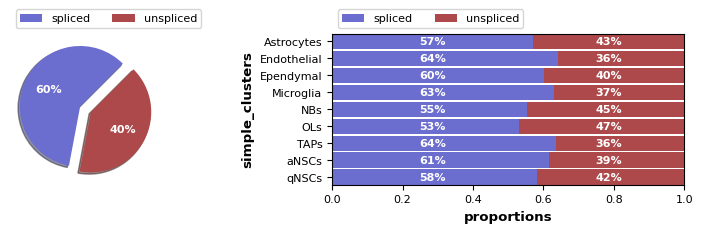

In [15]:
adata.obs['simple_clusters'] = adata.obs['simple_clusters'].astype('category')
scv.pl.proportions(adata, groupby='simple_clusters')

## Preprocessing the Data
Preprocessing consist of gene selection by minimum counts, normalizing every cell by its total size, gene selection by dispersion and logarithmizing X (assay RNA in Seurat, in our case will be the same as spliced). All these steps are ran when running `scv.pp.filter_and_normalize`. Analysis further require first and second order moments (means and uncenterd variance) among nearest neighbors in PCA space. We can change the parameters as we want, here are the default values, which will be enough in our case. If we had more cells, we could increase `n_neighbors`, and reduce it with few cells. We can also change the number of top genes to keep, but the more genes, the longer the velocity recovery will take.

In [16]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 18779 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Estimate RNA velocity
There are 3 main methods to estimate RNA velocity : deterministic, stochastic and dynamical.<br>
- The deterministic method is the less interesting of these 3, being the less precise, but is the original velocity method described in [La Manno et al. (2018)](https://www.nature.com/articles/s41586-018-0414-6).
- The stochastic method is the compromise between speed and precision. It is an upgrade of the deterministic method, and is as fast.
- The dynamical method is the most precise, but also the slowest, that allows us some more analysis like the latent time. It is described in [Bergen et al. (2020)](https://www.nature.com/articles/s41587-020-0591-3) 

We will focus on the dynamical method, the most precise.

### Dynamical method
The dynamical method requires two steps, the first one learn the full transcriptional dynamics of splicing kinetics, and the second one computes the velocity from these dynamics. It is possible to parallelize the dynamics recovering step, with the argument `n_jobs`.

In [17]:
scv.tl.recover_dynamics(adata, n_jobs = 32) # the most time consuming step

scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics (using 32/40 cores)


  0%|          | 0/1752 [00:00<?, ?gene/s]

    finished (0:05:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:15) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/11279 [00:00<?, ?cells/s]

    finished (0:00:50) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Visualize the velocity
There are 3 plotting methods to visualize the velocity on a UMAP. The grid, the stream and the base (my personnal favorite is the stream, but the base one might be better for a small number of cells). There are many grahical parameters that can be changed, see the [documentation](https://scvelo.readthedocs.io/api.html) for more info

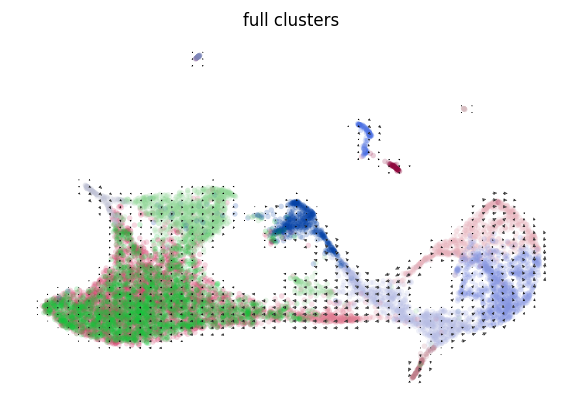

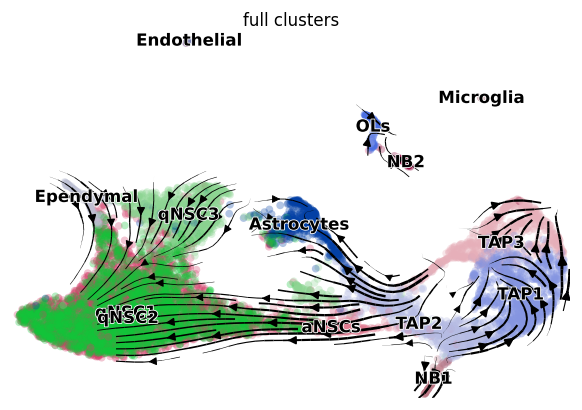

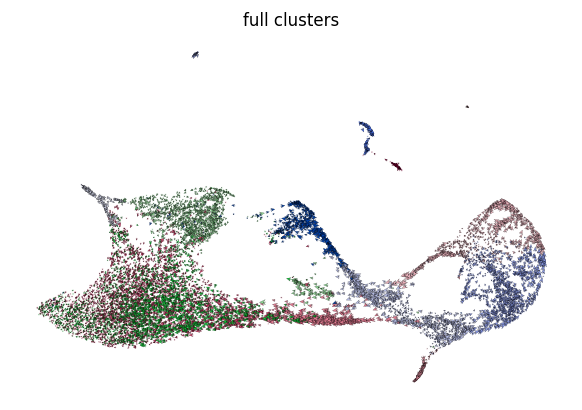

In [23]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='full_clusters', dpi=120)

scv.pl.velocity_embedding_stream(adata, basis='umap', color='full_clusters', dpi=120)

scv.pl.velocity_embedding(adata, arrow_length=4, arrow_size=4, dpi=120, color='full_clusters')

## Interprete the velocities
We can get an insight on the portrait phase of the genes we want (here for example 2 markers of TAPs and 2 markers of qNSCs). To interpret a portrait phase, see this [gif](https://user-images.githubusercontent.com/31883718/80227452-eb822480-864d-11ea-9399-56886c5e2785.gif).

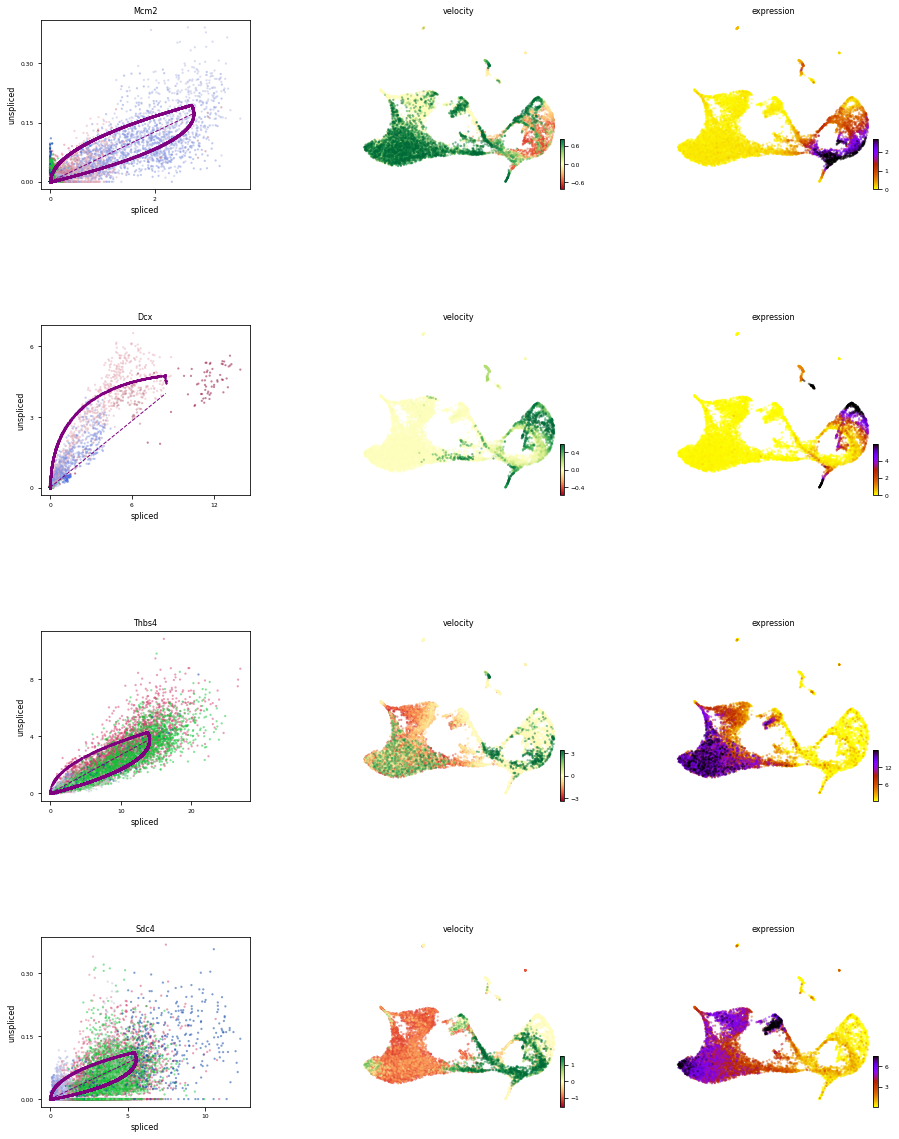

In [34]:
scv.pl.velocity(adata, ['Mcm2', 'Dcx',  'Thbs4', 'Sdc4'], ncols=1, color='full_clusters', figsize=(10,10), size=20)

A scatter plot is a representation showing the spliced vs unspliced phase of each cell for a given gene. We can color it along the column we want (here by clusters and by velocity).

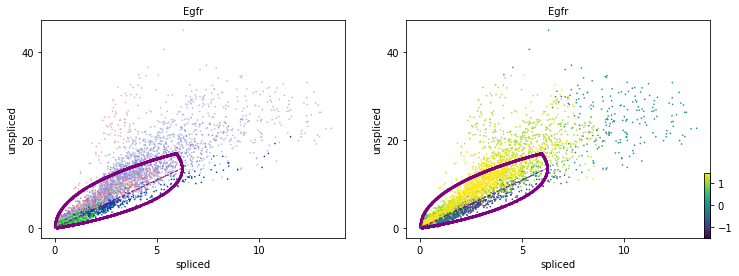

In [37]:
scv.pl.scatter(adata, 'Egfr', color=['full_clusters', 'velocity'])

## Identify important genes
To identify the genes responsible of the highest velocity in each of the clusters, we can ask scvelo to rank them for us by cluster. We can also save this dataframe of genes in a csv.

In [41]:
scv.tl.rank_velocity_genes(adata, groupby='full_clusters', min_corr=.3) # rank genes per cluster

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names']) # extract genes per cluster
df.to_csv("/mnt/Data1/public_vignettes/scvelo_data/velocity_genes_per_clusters.csv") # save genes as csv
df.head() # show first 5 genes for all clusters

ranking velocity genes
    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


,Astrocytes,Endothelial,Ependymal,Microglia,NB1,NB2,OLs,TAP1,TAP2,TAP3,aNSCs,qNSC1,qNSC2,qNSC3
0,Grin3a,Nap1l1,Paqr8,Ank3,Dcx,Zbtb18,Dbx2,Lockd,Xylt1,Sox1ot,Dusp18,Rps6,Tubb2a,Arid5a
1,Sesn3,Tsc22d3,Tob2,Zbtb18,B2m,Olfm2,Ncam1,Rad21,Chd3,Dpysl5,Oat,Dnah5,1700019G24Rik,Tceal5
2,Notch2,Zbtb18,Ptx3,Basp1,Zbtb18,Cd200,Prrx1,Cep55,Olfm2,Nsg1,Smarcc1,Cp,Rack1,Usp2
3,Gstt1,Acaa2,Tmem100,Hnrnpd,Insyn1,Topbp1,Acsl3,Kif18a,Pde10a,Miat,Pbxip1,Pgm5,AI413582,Pcdh7
4,Dlgap1,Glul,Fam111a,Nes,Nptx2,Insyn1,F3,Spc25,Elavl4,Prxl2a,Tmem100,Ppp1r3c,Pmp22,Csdc2


After ranking the genes, we can display the phase portrait of the top X we want from the clusters we want using a scatterplot, here we display the phase portrait of the top 5 genes in cluster qNSC1 and qNSC2.

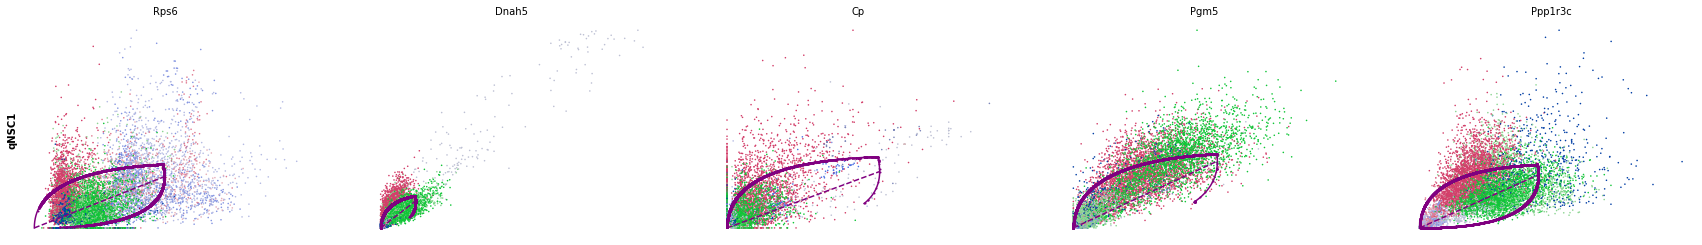

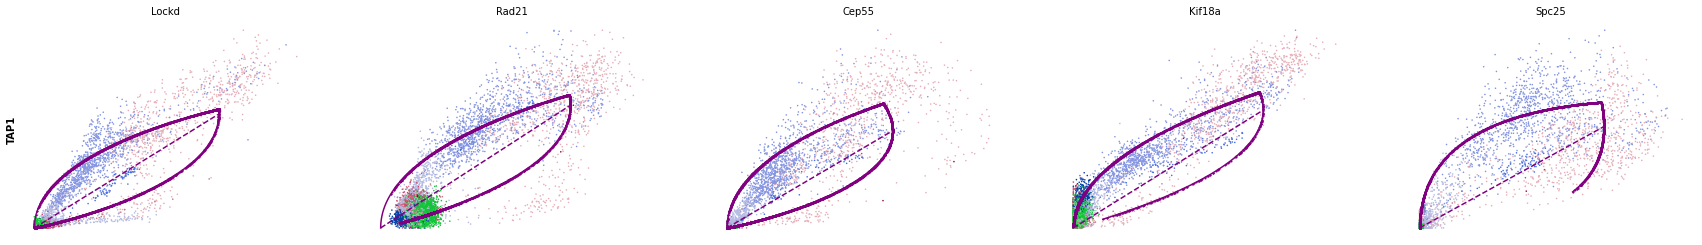

In [42]:
scv.pl.scatter(adata, df['qNSC1'][:5], ylabel='qNSC1', frameon=False, size=10, linewidth=1.5, color='full_clusters')
scv.pl.scatter(adata, df['TAP1'][:5], ylabel='TAP1', frameon=False, size=10, linewidth=1.5, color='full_clusters')

## Length and confidence
The velocity length is the speed at which the cells differentiate. A low value (less than 10) indicates that there is almost no differentation occuring, or that the differenciation is especially slow in this cell type.

The velocity confidence shows how much scvelo is confident about its prediction, it represents the proportion of neighboring cells that goes in the same direction. A low confidence indicates that scvelo is not sure about what is the direction of the velocity in this cell type.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


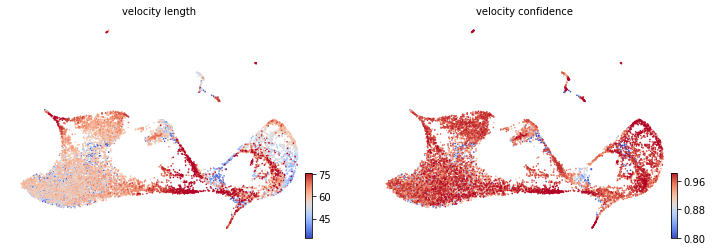

In [43]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

## Latent time
Latent time works only with the dynamical model, and it show the latent time of the underlying process. The latent time represents the cell's internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics. The latent time is what will give us the starting point of the cells, which we will use in the `Analysing pseudotime` vignette.

computing terminal states
    identified 5 regions of root cells and 4 regions of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


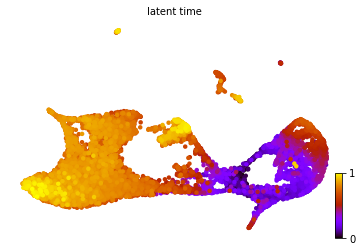

In [44]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

As we could have already guess from the velocity arrows, the starting point of the differentiation is located in the TAP2 cluster.

We can view the top X genes indicative of the latent time in a heatmap. Parameter `yticklabels` change the number of gene names displayed, setting it to `True` will display all gene names, setting it to `False` will not display any gene name, and removing it will display some genes, depending on the plot size. The `n_convolve` parameter change the smoothing of the displayed heatmap, put it to `1` to get the real representation of the data.

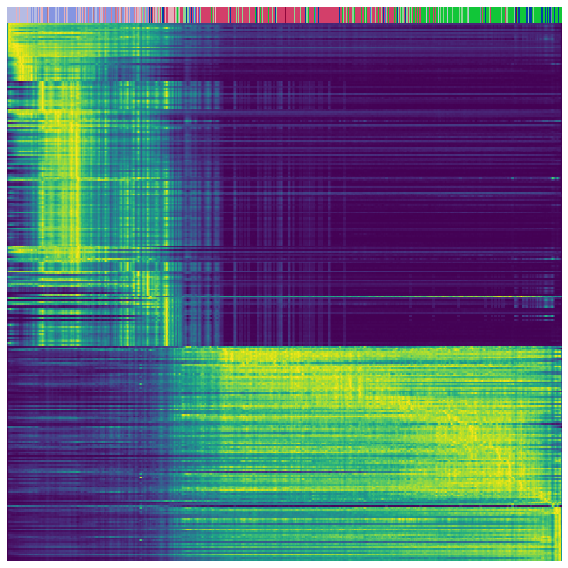

In [50]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='full_clusters', 
               n_convolve=50, yticklabels=False, figsize=(8, 8))

## Save and load the velocity object
We will save the velocity object as `.dp` file, using the library `pickle`.

In [51]:
pickle.dump(adata, open("/mnt/Data1/public_vignettes/scvelo_data/velocity.dp", "wb"))

To load the object, we also use tthe library `pickle`.

In [52]:
adata = pickle.load(open("/mnt/Data1/public_vignettes/scvelo_data/velocity.dp", "rb"))